In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, ConnectionPatch
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.colors import ListedColormap
from matplotlib.colors import to_rgba

# ML
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_classification


# Atoms
from ase.io import read
from soap import extract_species_pair_groups

# Utilities
import h5py
from tools import load_json
from tqdm.notebook import tqdm
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Analysis setup

In [3]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [4]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [5]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [6]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)
n_deem = len(deem_cantons_2)

In [7]:
# Build set of "master" canton labels for the train set
train_cantons = {}

train_cantons[4] = np.concatenate((
    iza_cantons[iza_train_idxs], 
    deem_cantons_4[deem_train_idxs]
))

train_cantons[2] = np.concatenate((
    np.ones(len(iza_train_idxs), dtype=int),
    deem_cantons_2[deem_train_idxs]
))

train_class_weights = {
    n_cantons: utils.balanced_class_weights(train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Build set of "master" canton labels for the test set
test_cantons = {}

test_cantons[4] = np.concatenate((
    iza_cantons[iza_test_idxs], 
    deem_cantons_4[deem_test_idxs]
))

test_cantons[2] = np.concatenate((
    np.ones(len(iza_test_idxs), dtype=int),
    deem_cantons_2[deem_test_idxs]
))

test_class_weights = {
    n_cantons: utils.balanced_class_weights(test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [8]:
# Load dummy Deem cantons to test the "null" case
dummy_cantons = {}
dummy_cantons[2] = np.loadtxt('../../Processed_Data/DEEM_330k/Data/dummy_cantons_2-class.dat', dtype=int)
dummy_cantons[4] = np.loadtxt('../../Processed_Data/DEEM_330k/Data/dummy_cantons_4-class.dat', dtype=int)

In [9]:
# Master set of dummy labels for the train set
dummy_train_cantons = {}
dummy_train_cantons[2] = dummy_cantons[2][deem_train_idxs]
dummy_train_cantons[4] = dummy_cantons[4][deem_train_idxs]

dummy_train_class_weights = {
    n_cantons: utils.balanced_class_weights(dummy_train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Master set of dummy labels for the test set
dummy_test_cantons = {}
dummy_test_cantons[2] = dummy_cantons[2][deem_test_idxs]
dummy_test_cantons[4] = dummy_cantons[4][deem_test_idxs]

dummy_test_class_weights = {
    n_cantons: utils.balanced_class_weights(dummy_test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [10]:
class_names = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']

}

ticklabels = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']
}

dummy_ticklabels = {
    2: ['DEEM1', 'DEEM2'],
    4: ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4']
}

In [11]:
# Linear model setup
n_species = 2
group_names = {
    'power': ['OO', 'OSi', 'SiSi', 'OO+OSi', 'OO+SiSi', 'OSi+SiSi', 'OO+OSi+SiSi'], 
    'radial': ['O', 'Si', 'O+Si']
}

In [12]:
deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

# LR check

In [ ]:
batch_size = 100000

In [ ]:
for cutoff in tqdm(cutoffs, desc='Cutoff', leave=True):
    
    for spectrum_type in tqdm(('power', 'radial'), desc='Spectrum', leave=False):
        spectrum_name = spectrum_type.capitalize()
        
        # Load SOAPs
        iza_file = f'{iza_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        iza_soaps = utils.load_hdf5(iza_file)
        
        deem_file = f'{deem_dir}/{cutoff}/soaps_{spectrum_type}_full_avg_nonorm.hdf5'
        f = h5py.File(deem_file, 'r')
        deem_330k_dataset = f['0']
        
        train_soaps = np.vstack((iza_soaps[iza_train_idxs], deem_330k_dataset[deem_train_idxs]))
        
        n_features = train_soaps.shape[1]
        feature_groups = extract_species_pair_groups(
            n_features, n_species, 
            spectrum_type=spectrum_type,
            combinations=True
        )
        
        # Prepare batches for LR
        n_samples_330k = len(deem_test_idxs)
        n_batches = n_samples_330k // batch_size
        if n_samples_330k % batch_size > 0:
            n_batches += 1
        
        for species_pairing, feature_idxs in zip(
            tqdm(group_names[spectrum_type], desc='Species', leave=False),
            feature_groups
        ):
                        
            for n_cantons in tqdm((2, 4), desc='Classes', leave=False):              
                
                # Load decision functions
                df_dir = f'LSVC/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
                
                # Load decision functions
                iza_dfs = np.loadtxt(f'{iza_dir}/{cutoff}/{df_dir}/svc_structure_dfs.dat')
                deem_dfs = np.loadtxt(f'{deem_dir}/{cutoff}/{df_dir}/svc_structure_dfs.dat')
                
                train_dfs = np.concatenate((iza_dfs[iza_train_idxs], deem_dfs[deem_train_idxs]))
                test_dfs = np.concatenate((iza_dfs[iza_test_idxs], deem_dfs[deem_test_idxs]))
                     
                # Need to preprocess y (the decision functions) by hand since TransformedTargetRegressor
                # doesn't pass any fit_params to the transformer
                df_scaler = utils.StandardNormScaler(featurewise=True)
                scaled_train_dfs = df_scaler.fit_transform(
                    train_dfs, sample_weight=train_class_weights[n_cantons]
                )
                
                pipeline = Pipeline(
                    [
                        ('norm_scaler', utils.StandardNormScaler()),
                        ('ridge', Ridge(alpha=1.0E-10)),
                    ],
                )
                fit_params = {
                    'norm_scaler__sample_weight': train_class_weights[n_cantons], 
                    'ridge__sample_weight': train_class_weights[n_cantons],
                }
                pipeline.fit(train_soaps, scaled_train_dfs, **fit_params)
                
                predicted_iza_dfs = pipeline.predict(iza_soaps[iza_test_idxs])
                predicted_iza_dfs = df_scaler.inverse_transform(predicted_iza_dfs)
                
                predicted_deem_dfs = np.zeros(deem_dfs[deem_test_idxs].shape)       
                for i in tqdm(range(0, n_batches), desc='Batch', leave=False):
                    batch_slice = slice(i * batch_size, (i + 1) * batch_size)
                    batch_idxs = deem_test_idxs[batch_slice]
                    
                    deem_330k_batch = deem_330k_dataset[batch_idxs]
                    predicted_deem_dfs[batch_slice] = pipeline.predict(deem_330k_batch)
                
                predicted_deem_dfs = df_scaler.inverse_transform(predicted_deem_dfs)
                predicted_dfs = np.concatenate((predicted_iza_dfs, predicted_deem_dfs))
                
                mae = mean_absolute_error(
                    test_dfs, predicted_dfs, 
                    sample_weight=test_class_weights[n_cantons],
                    multioutput='raw_values'
                )
                rmse = mean_squared_error(
                    test_dfs, predicted_dfs, 
                    sample_weight=test_class_weights[n_cantons], 
                    squared=False, multioutput='raw_values'
                )
                
                print(f'-----{n_cantons}-Class {spectrum_name} {species_pairing}-----')
                print(f'Test MAE = {mae}')
                print(f'Test RMSE = {rmse}')
                print()
        
        f.close()

# Classification statistics

In [15]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'LSVC/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')

                predicted_cantons_iza = np.loadtxt(
                    f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )
                predicted_cantons_deem = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )

                predicted_train_cantons = np.concatenate((
                    predicted_cantons_iza[iza_train_idxs],
                    predicted_cantons_deem[deem_train_idxs]
                ))
                predicted_test_cantons = np.concatenate((
                    predicted_cantons_iza[iza_test_idxs],
                    predicted_cantons_deem[deem_test_idxs]
                ))

                # TODO: weighted confusion matrices
                matrix_train = confusion_matrix(
                    train_cantons[n_cantons], predicted_train_cantons
                )
                matrix_test = confusion_matrix(
                    test_cantons[n_cantons], predicted_test_cantons
                )

                print('----- Train -----')
                print(
                    classification_report(
                        train_cantons[n_cantons], predicted_train_cantons, zero_division=0
                    )
                )
                print('Train accuracy:', balanced_accuracy_score(
                    train_cantons[n_cantons], predicted_train_cantons
                ))
                print()
                print(matrix_train)
                print()

                print('----- Test -----')
                print(
                    classification_report(
                        test_cantons[n_cantons], predicted_test_cantons, zero_division=0
                    )
                )
                print('Test accuracy:', balanced_accuracy_score(
                    test_cantons[n_cantons], predicted_test_cantons
                ))
                print()
                print(matrix_test)
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.11      0.99      0.19       114
           2       1.00      0.91      0.95      9999

    accuracy                           0.91     10113
   macro avg       0.55      0.95      0.57     10113
weighted avg       0.99      0.91      0.94     10113

Train accuracy: 0.9487093446186724

[[ 113    1]
 [ 938 9061]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.88      0.01       115
           2       1.00      0.91      0.95    321083

    accuracy                           0.91    321198
   macro avg       0.50      0.89      0.48    321198
weighted avg       1.00      0.91      0.95    321198

Test accuracy: 0.8918622829340213

[[   101     14]
 [ 30354 290729]]

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.02  

Test accuracy: 0.5927007922713083

[[    15      3      0      0]
 [    16     32      5      2]
 [     6     25      3      8]
 [ 18753  13612   4809 283909]]

===== 3.5 | 2-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12      0.99      0.22       114
           2       1.00      0.92      0.96      9999

    accuracy                           0.92     10113
   macro avg       0.56      0.95      0.59     10113
weighted avg       0.99      0.92      0.95     10113

Train accuracy: 0.9548099546796784

[[ 113    1]
 [ 816 9183]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.93      0.01       115
           2       1.00      0.92      0.96    321083

    accuracy                           0.92    321198
   macro avg       0.50      0.92      0.48    321198
weighted avg       1.00      0.92      0.96    321198

Test accuracy: 0.9228591848592853

[[   10

----- Train -----
              precision    recall  f1-score   support

           1       0.05      0.89      0.09       114
           2       1.00      0.81      0.89      9999

    accuracy                           0.81     10113
   macro avg       0.52      0.85      0.49     10113
weighted avg       0.99      0.81      0.88     10113

Train accuracy: 0.8462227801727541

[[ 101   13]
 [1935 8064]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.83      0.00       115
           2       1.00      0.81      0.89    321083

    accuracy                           0.81    321198
   macro avg       0.50      0.82      0.45    321198
weighted avg       1.00      0.81      0.89    321198

Test accuracy: 0.8162709926418863

[[    95     20]
 [ 62144 258939]]

===== 3.5 | 4-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.02      0.88      0.04        17
         

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.72      0.00        18
           2       0.00      0.00      0.00        55
           3       0.00      0.40      0.00        42
           4       1.00      0.78      0.87    321083

    accuracy                           0.78    321198
   macro avg       0.25      0.48      0.22    321198
weighted avg       1.00      0.78      0.87    321198

Test accuracy: 0.4759621690064909

[[    13      0      5      0]
 [    30      0     20      5]
 [    11      0     17     14]
 [ 22938     17  48690 249438]]

===== 3.5 | 2-Class | Radial | O+Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.08      0.91      0.15       114
           2       1.00      0.89      0.94      9999

    accuracy                           0.89     10113
   macro avg       0.54      0.90      0.55     10113
weighted avg       0.99      0.89      0.93     10113

Train accuracy: 0

              precision    recall  f1-score   support

           1       0.01      0.56      0.01        18
           2       0.00      0.60      0.01        55
           3       0.01      0.33      0.01        42
           4       1.00      0.96      0.98    321083

    accuracy                           0.96    321198
   macro avg       0.25      0.61      0.25    321198
weighted avg       1.00      0.96      0.98    321198

Test accuracy: 0.612595427904242

[[    10      8      0      0]
 [    10     33      8      4]
 [     1     15     14     12]
 [  1534   8187   2643 308719]]

===== 6.0 | 2-Class | Power | OO+OSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.31      1.00      0.48       114
           2       1.00      0.97      0.99      9999

    accuracy                           0.98     10113
   macro avg       0.66      0.99      0.73     10113
weighted avg       0.99      0.98      0.98     10113

Train accuracy: 0

              precision    recall  f1-score   support

           1       0.01      0.72      0.01        18
           2       0.00      0.55      0.01        55
           3       0.00      0.36      0.01        42
           4       1.00      0.95      0.97    321083

    accuracy                           0.95    321198
   macro avg       0.25      0.64      0.25    321198
weighted avg       1.00      0.95      0.97    321198

Test accuracy: 0.6434823391428071

[[    13      5      0      0]
 [    15     30      7      3]
 [     2     17     15      8]
 [  2489   8039   5812 304743]]

===== 6.0 | 2-Class | Radial | O =====
----- Train -----
              precision    recall  f1-score   support

           1       0.16      0.96      0.27       114
           2       1.00      0.94      0.97      9999

    accuracy                           0.94     10113
   macro avg       0.58      0.95      0.62     10113
weighted avg       0.99      0.94      0.96     10113

Train accuracy: 0.94

# Confusion matrices

## IZA + Deem

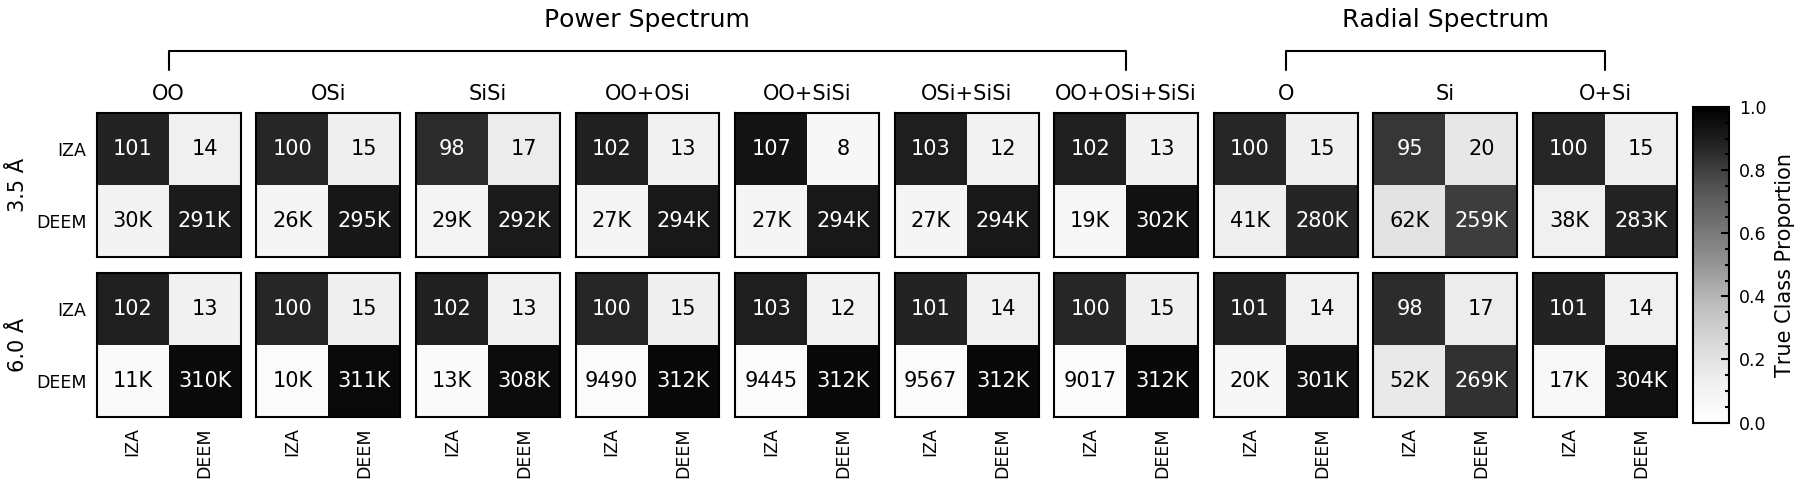

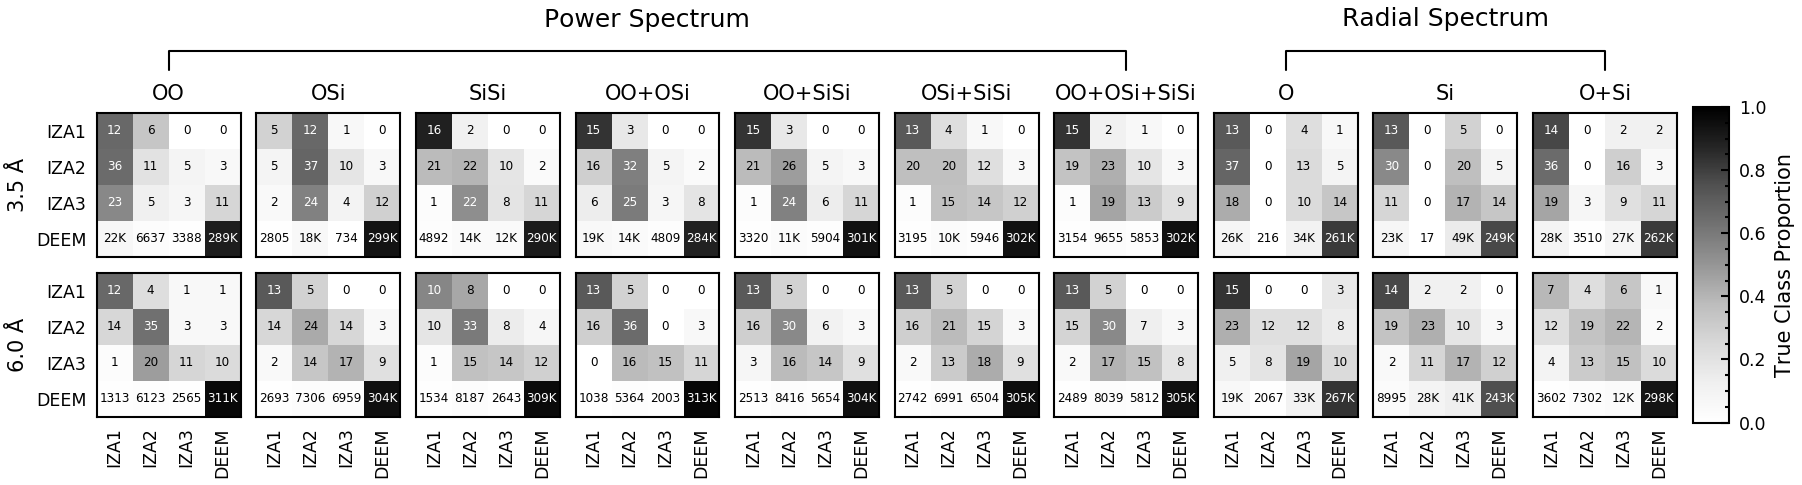

In [16]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0
vmax = 1.0

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(
        nrows=n_rows, ncols=n_cols+1, 
        width_ratios=width_ratios,
        hspace=0.05, wspace=0.05
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'LSVC/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                predicted_cantons_iza = np.loadtxt(
                    f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )
                predicted_cantons_deem = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )

                predicted_train_cantons = np.concatenate((
                    predicted_cantons_iza[iza_train_idxs],
                    predicted_cantons_deem[deem_train_idxs]
                ))
                predicted_test_cantons = np.concatenate((
                    predicted_cantons_iza[iza_test_idxs],
                    predicted_cantons_deem[deem_test_idxs]
                ))

                matrix_train = confusion_matrix(train_cantons[n_cantons], predicted_train_cantons)
                matrix_test = confusion_matrix(test_cantons[n_cantons], predicted_test_cantons)

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                
                for i in range(0, n_cantons):
                    matrix_ref[i, i] = np.count_nonzero(test_cantons[n_cantons] == (i + 1))
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Greys', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                            
                        if len(str(matrix_test[i, j])) > 4:
                            
                            # This isn't a very 'robust' way of doing this,
                            # but since we only go up to 6 digits, this should work
                            # (we do this shortening only if the number has 6 digits)
                            box_number_str = str(round(matrix_test[i, j], -3))
                            box_number_str = box_number_str[0:-3] + 'K'
                        else:
                            box_number_str = f'{matrix_test[i, j]:d}'
                        
                        ax.text(
                            j, i, box_number_str,
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size
                        )
                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(
                    axis='both', which='both', 
                    left=False, bottom=False, right=False, top=False,
                    labelleft=False, labelbottom=False, labelright=False, labeltop=False
                )
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
                    ax.set_title(f'{species_pairing}', fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(ticklabels[n_cantons], rotation=90)
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 0].transAxes,
        xyB=cp_xy, coordsB=axes[0, 6].transAxes,
        connectionstyle=f'bar,fraction={cp_power_bar_frac}'
    )
    cp_radial = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 7].transAxes,
        xyB=cp_xy, coordsB=axes[0, 9].transAxes,
        connectionstyle=f'bar,fraction={cp_radial_bar_frac}'
    )
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(
        0.5 - power_shift, 1.65, 'Power Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=power_label_ax.transAxes, fontsize='large'
    )
    
    fig.text(
        0.5 - radial_shift, 1.65, 'Radial Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=radial_label_ax.transAxes, fontsize='large'
    )
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(
        ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Greys'), cax=cax
    )
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    
    fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

## Dummy prediction

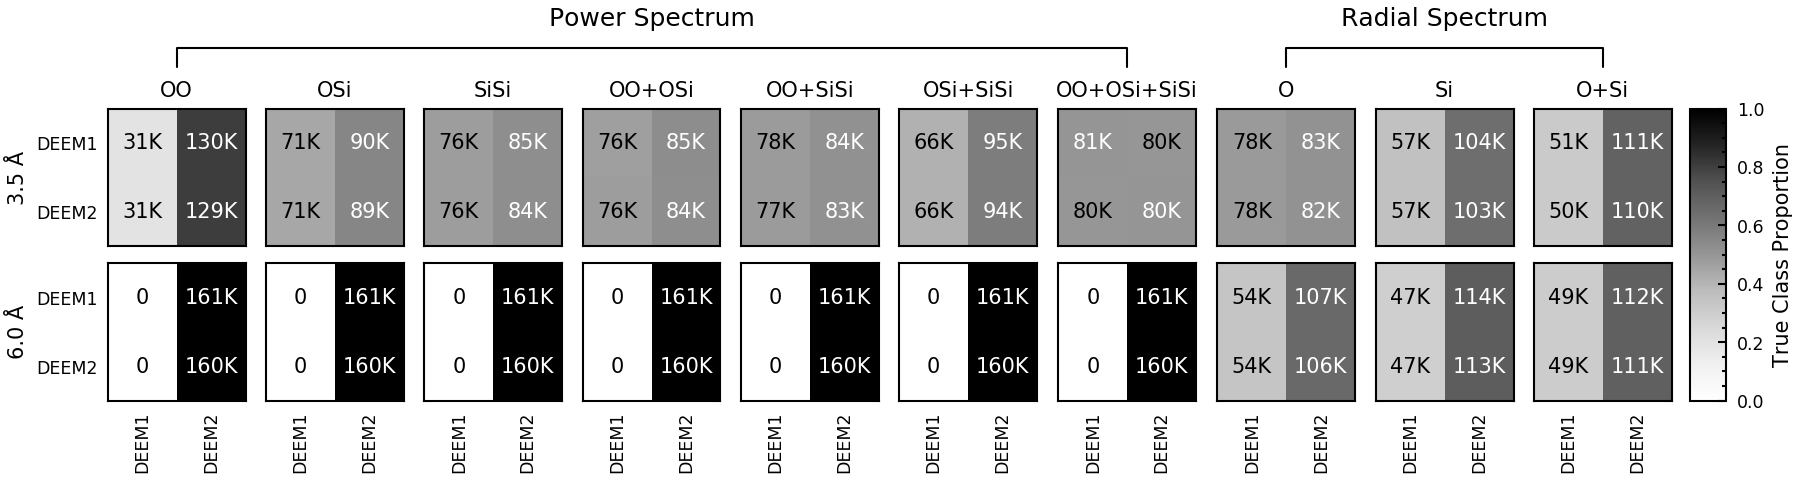

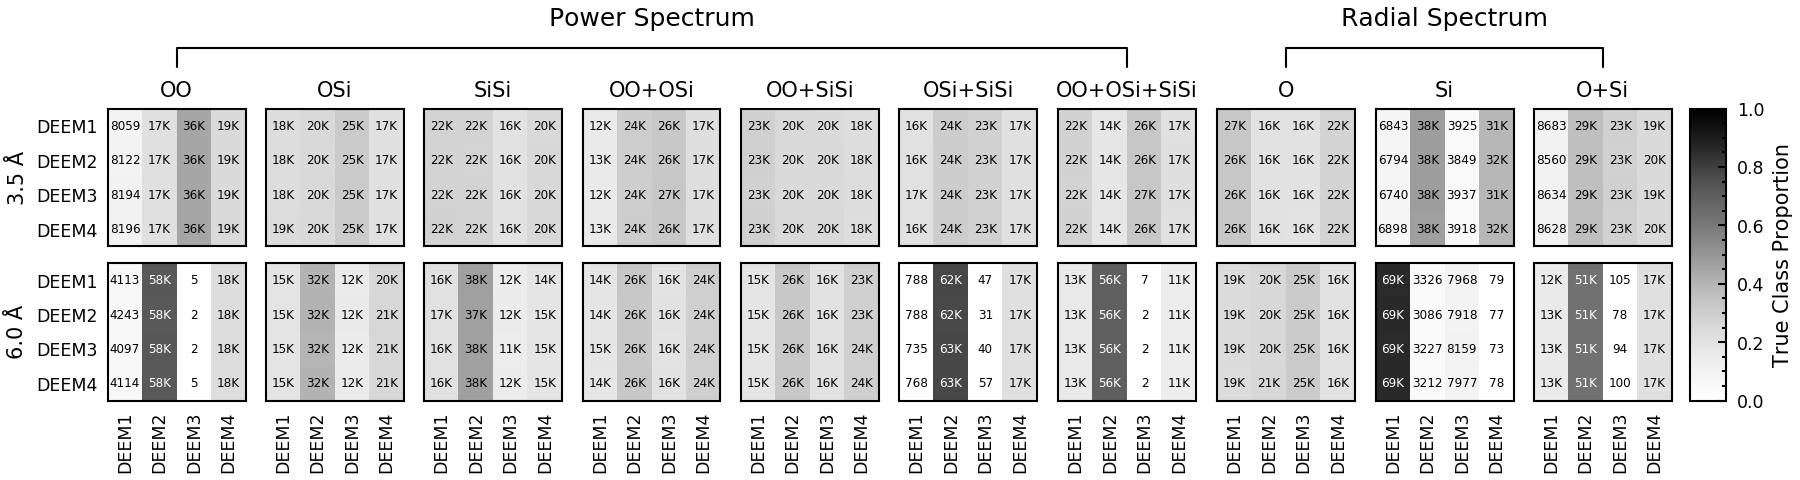

In [112]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0
vmax = 1.0

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(
        nrows=n_rows, ncols=n_cols+1, 
        width_ratios=width_ratios,
        hspace=0.05, wspace=0.05
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'LSVC/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                predicted_dummy_cantons = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int
                )
                predicted_dummy_train_cantons = predicted_dummy_cantons[deem_train_idxs]
                predicted_dummy_test_cantons = predicted_dummy_cantons[deem_test_idxs]

                matrix_train = confusion_matrix(
                    dummy_train_cantons[n_cantons], predicted_dummy_train_cantons
                )
                matrix_test = confusion_matrix(
                    dummy_test_cantons[n_cantons], predicted_dummy_test_cantons
                )

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                
                for i in range(0, n_cantons):
                    matrix_ref[i, i] = np.count_nonzero(dummy_test_cantons[n_cantons] == (i + 1))
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Greys', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                            
                        if len(str(matrix_test[i, j])) > 4:
                            
                            # This isn't a very 'robust' way of doing this,
                            # but since we only go up to 6 digits, this should work
                            # (we do this shortening only if the number has 6 digits)
                            box_number_str = str(round(matrix_test[i, j], -3))
                            box_number_str = box_number_str[0:-3] + 'K'
                        else:
                            box_number_str = f'{matrix_test[i, j]:d}'
                        
                        ax.text(
                            j, i, box_number_str,
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size
                        )
                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(
                    axis='both', which='both', 
                    left=False, bottom=False, right=False, top=False,
                    labelleft=False, labelbottom=False, labelright=False, labeltop=False
                )
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(dummy_ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
                    ax.set_title(f'{species_pairing}', fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(dummy_ticklabels[n_cantons], rotation=90)
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 0].transAxes,
        xyB=cp_xy, coordsB=axes[0, 6].transAxes,
        connectionstyle=f'bar,fraction={cp_power_bar_frac}'
    )
    cp_radial = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 7].transAxes,
        xyB=cp_xy, coordsB=axes[0, 9].transAxes,
        connectionstyle=f'bar,fraction={cp_radial_bar_frac}'
    )
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(
        0.5 - power_shift, 1.65, 'Power Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=power_label_ax.transAxes, fontsize='large'
    )
    
    fig.text(
        0.5 - radial_shift, 1.65, 'Radial Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=radial_label_ax.transAxes, fontsize='large'
    )
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(
        ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Greys'), cax=cax
    )
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    
    fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

# ROC curves

3.5-Power-OO: 1.1587528092416912
3.5-Power-OSi: 1.1839398671295873
3.5-Power-SiSi: 1.221659173202084
3.5-Power-OO+OSi: 1.198000383677376
3.5-Power-OO+SiSi: 1.3770120346039414
3.5-Power-OSi+SiSi: 1.225449910606726
3.5-Power-OO+OSi+SiSi: 1.2950724152547948
3.5-Radial-O: 1.1670426559739289
3.5-Radial-Si: 0.8660051441274987
3.5-Radial-O+Si: 1.1677224145470098
6.0-Power-OO: 1.4702321509823972
6.0-Power-OSi: 1.548377187927826
6.0-Power-SiSi: 1.3857316476208883
6.0-Power-OO+OSi: 1.5246754652456322
6.0-Power-OO+SiSi: 1.532162490454839
6.0-Power-OSi+SiSi: 1.5842854715112347
6.0-Power-OO+OSi+SiSi: 1.561983607266052
6.0-Radial-O: 1.3362458886917792
6.0-Radial-Si: 1.0648026842376601
6.0-Radial-O+Si: 1.3759175198074525


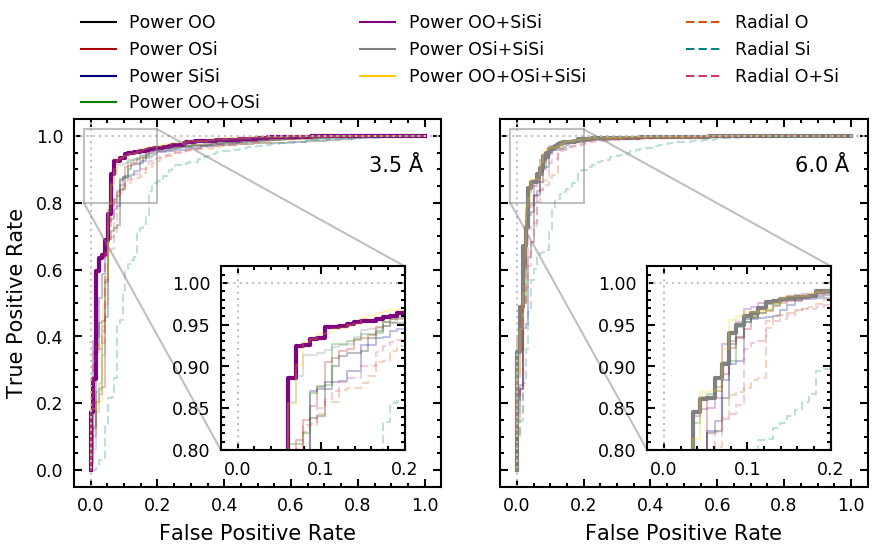

In [17]:
# ROC curves
fig = plt.figure(figsize=(7.0, 7.0))
axs = {}
axs[3.5] = fig.add_subplot(2, 2, 1)
axs[6.0] = fig.add_subplot(2, 2, 2)
legend_lines = {cutoff: [] for cutoff in cutoffs}

plot_parameters = dict(power={'linestyle': '-'}, radial={'linestyle': '--'})

for cutoff in cutoffs:
    model_dir = f'../../Processed_Data/Models/{cutoff}'
    axs[cutoff].set_aspect('equal')
    axs_inset = axs[cutoff].inset_axes([0.40, 0.10, 0.50, 0.50])
    roc_line_pairs = []
    max_auc = 0.0
    max_auc_idx = 0
    plot_idx = 0
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        plot_parameters['linestyle'] = ''
        for species_pairing in group_names[spectrum_type]:
            data_dir = f'LSVC/2-Class/{spectrum_name}/{species_pairing}'
            
            dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            
            test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))
            
            fpr, tpr, thresholds = roc_curve(
                test_cantons[2], 
                test_dfs,
                pos_label=2
            )
            auc = roc_auc_score(
                test_cantons[2],
                test_dfs,
                average='macro'
            )
            if auc > max_auc:
                max_auc = auc
                max_auc_idx = plot_idx
                
            plot_idx += 1
            #print(f'{cutoff}-{spectrum_name}-{species_pairing}: {auc}')
            print(f'{cutoff}-{spectrum_name}-{species_pairing}: {-np.log10(1.0-auc)}')
            
            line_pair = []
            for ax in (axs[cutoff], axs_inset):
                line = ax.plot(fpr, tpr, **plot_parameters[spectrum_type], 
                        label=f'{spectrum_name} {species_pairing}')
                line_pair.extend(line)
            roc_line_pairs.append(line_pair)
    
    for ldx, line_pair in enumerate(roc_line_pairs):
        legend_lines[cutoff].append(Line2D(
            [0], [0], 
            label=line_pair[0].get_label(), 
            color=line_pair[0].get_color(),
            linestyle=line_pair[0].get_linestyle(),
            alpha=1.0
        ))

        if ldx == max_auc_idx:
            color_transparency = ''
            line_scale = 2
        else:
            color_transparency = '40' # Hex for alpha = 0.25
            line_scale = 1
            
        for line in line_pair:
            line.set_color(line.get_color() + color_transparency)
            line.set_linewidth(line.get_linewidth() * line_scale)
                            
    zoom_x = ([-0.02, 0.20])
    zoom_y = ([0.80, 1.02])
    axs_inset.set_xlim(zoom_x)
    axs_inset.set_ylim(zoom_y)    
                
    for ax in (axs[cutoff], axs_inset):        
        ax.axvline(0.0, color=color_list[11], linestyle=':')
        ax.axhline(1.0, color=color_list[11], linestyle=':')
        
    axs[cutoff].indicate_inset_zoom(axs_inset, label=None)

    #axs[cutoff].set_xlim([-0.01, 0.2])
    axs[cutoff].set_xlabel('False Positive Rate')
    
    axs[cutoff].text(0.95, 0.90, f'{cutoff} ' + u'\u00c5',
                     horizontalalignment='right', verticalalignment='top',
                     transform=axs[cutoff].transAxes)
    
    # TODO: save AUC so we can put them in a table

wspace=0.1
axs[3.5].set_ylabel('True Positive Rate')

axs[3.5].legend(handles=legend_lines[3.5], bbox_to_anchor=(0.0, 1.0, 2.0+wspace, 0.5), 
                loc='lower left', bbox_transform=axs[3.5].transAxes,
                ncol=3, mode='expand', borderaxespad=0.0)

axs[6.0].tick_params(axis='y', which='both', labelleft=False)

fig.subplots_adjust(wspace=wspace)

fig.savefig('../../Results/roc_svc.pdf', bbox_inches='tight')

plt.show()

In [115]:
X

array([[-0.09974296, -1.70605142],
       [-0.82878672,  0.53680201],
       [-0.92689922,  1.02662418],
       [ 3.12517866,  0.98620969],
       [-1.37653776,  1.79302957],
       [-1.04717057,  1.31471069],
       [ 0.42070001, -0.76073832],
       [-1.52998076, -1.59500861],
       [ 1.52058089,  1.16966272],
       [-1.38904931, -1.82660002],
       [-0.05018274,  0.57879094],
       [ 0.31186184, -0.32750302],
       [ 0.60560597,  1.01255241],
       [-1.02228502, -0.90425208],
       [-1.54195779, -1.04668764],
       [-0.07440832,  0.1741922 ],
       [ 1.32937436, -0.19691761],
       [-2.50736   ,  1.37035939],
       [ 1.157971  ,  1.28618119],
       [-1.24038743, -1.37196835]])

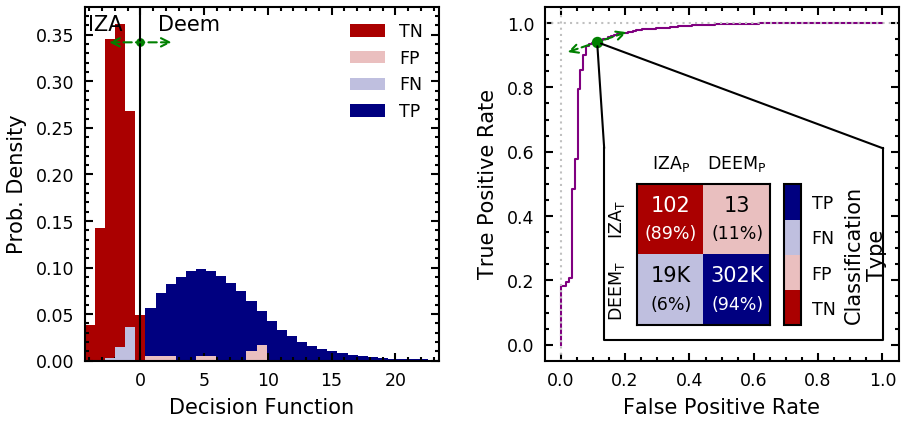

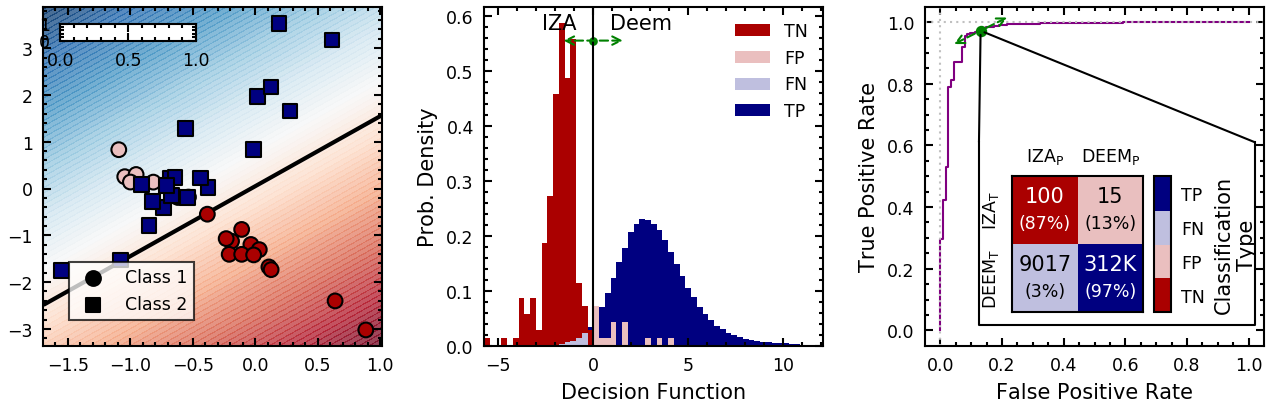

In [150]:
# Custom colors for classes
matrix_colors = [
    np.array(to_rgba(c, alpha=1.0)) for c in [color_list[1], color_list[1], color_list[2], color_list[2]]
]
white_mix = 0.75
for i in range(1, 3):
    matrix_colors[i] = white_mix * np.ones(4) + (1.0 - white_mix) * matrix_colors[i]

cmap = ListedColormap(matrix_colors)
cmap_norm = BoundaryNorm(np.arange(0, cmap.N + 1), cmap.N)

# "Best" ROC curve with confusion matrix inset
for cutoff in cutoffs:    
    if cutoff == 6.0:
        fig = plt.figure(figsize=(10.5, 3.5))
        n_plots = 3
        toy_axs = fig.add_subplot(1, n_plots, 1)
        X, y = make_classification(
            n_samples=40,
            n_features=2,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            class_sep=0.50,
            random_state=None
        )
        svc = SVC(kernel='linear', class_weight='balanced')
        svc.fit(X, y)
        
        yp = svc.predict(X)
        y_colors = np.zeros(len(y), dtype=int)
        y_colors[(yp == 0) & (y == 0)] = 0 # TN
        y_colors[(yp == 1) & (y == 0)] = 1 # FP
        y_colors[(yp == 0) & (y == 1)] = 2 # FN
        y_colors[(yp == 1) & (y == 1)] = 3 # TP
        for cls, marker in zip((0, 1), ('o', 's')):
            toy_axs.scatter(
                X[y == cls, 0], X[y == cls, 1],
                marker=marker, c=y_colors[y == cls], s=50,
                cmap=cmap, norm=cmap_norm, edgecolor='k', 
                label=f'Class {cls+1}', zorder=2
            )
            
        toy_xlim = toy_axs.get_xlim()
        toy_ylim = toy_axs.get_ylim()
        toy_axs.set_aspect((toy_xlim[1] - toy_xlim[0]) / (toy_ylim[1] - toy_ylim[0]), anchor='C')
        
        n_grid = 50
        xx, yy = np.meshgrid(
            np.linspace(toy_xlim[0], toy_xlim[1], n_grid),
            np.linspace(toy_ylim[0], toy_ylim[1], n_grid)
        )
        df_toy = np.reshape(
            svc.decision_function(np.column_stack((xx.flatten(), yy.flatten()))),
            (n_grid, n_grid)
        )
        # TODO: make this cmap match the TP and TN
        toy_axs.contourf(xx, yy, df_toy, levels=100, cmap='RdBu', alpha=0.75, zorder=0)
        toy_axs.contour(xx, yy, df_toy, levels=[0], linewidths=2, linestyles='-', colors='k', zorder=1)
        
        toy_cb = toy_axs.inset_axes([0.05, 0.90, 0.40, 0.05])
        
        # TODO: correct marker colors
        toy_axs.legend(
            loc='lower left', bbox_to_anchor=(0.05, 0.05),
            frameon=True, framealpha=0.75
        )
        
        # TODO: colorbar inset
        # TODO: ROC sweep
        # TODO: label decision boundary and misclassified points
        # TODO: remove ticks and labels
        
    else:
        fig = plt.figure(figsize=(7.0, 3.5))
        n_plots = 2
    
    roc_axs = fig.add_subplot(1, n_plots, n_plots)
    roc_axs.set_aspect('equal', anchor='C')
    df_axs = fig.add_subplot(1, n_plots, n_plots-1)    
    
    model_dir = f'../../Processed_Data/Models/6.0'
    data_dir = f'LSVC/2-Class/Power/OO+OSi+SiSi'

    dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
    dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

    test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))
    
    predicted_cantons_iza = np.loadtxt(
        f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )
    predicted_cantons_deem = np.loadtxt(
        f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )
        
    predicted_test_cantons = np.concatenate((
        predicted_cantons_iza[iza_test_idxs], 
        predicted_cantons_deem[deem_test_idxs]
    ))
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(
        test_cantons[2], 
        test_dfs,
        pos_label=2
    )

    auc = roc_auc_score(
        test_cantons[2],
        test_dfs,
        average='macro'
    )
    
    roc_axs.plot(fpr, tpr, color=color_list[4])

    roc_axs.axvline(0.0, color=color_list[11], linestyle=':')
    roc_axs.axhline(1.0, color=color_list[11], linestyle=':')

    #roc_axs.set_xlim([-0.01, 0.20])
    #roc_axs.set_ylim([0.80, 1.0])
    roc_axs.set_xlabel('False Positive Rate')
    roc_axs.set_ylabel('True Positive Rate')

    # Confusion matrix inset
    vmin = 0.0
    vmax = 1.0

    matrix_test = confusion_matrix(
        test_cantons[2], 
        predicted_test_cantons
    )
    
    # See https://en.wikipedia.org/wiki/Receiver_operating_characteristic
    # sklearn confusion matrix format: 
    #     https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    #     i.e, C[0, 0] = TN, C[0, 1] = FP, C[1, 0] = FN, C[1, 1] = TP
    # Need weighting?
    tpr_matrix = matrix_test[1, 1] / np.sum(matrix_test[1, :])
    fpr_matrix = matrix_test[0, 1] / np.sum(matrix_test[0, :])
        
    roc_axs.scatter(fpr_matrix, tpr_matrix, marker='o', s=20, zorder=3, color=color_list[3])

    matrix_ref = np.zeros((2, 2), dtype=int)
    for i in range(0, 2):
        matrix_ref[i, i] = np.count_nonzero(test_cantons[2] == (i + 1))

    matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

    roc_axs_in = roc_axs.inset_axes([0.25, 0.10, 0.40, 0.40])

    matshow = roc_axs_in.imshow(np.arange(0, 4).reshape(2, 2), cmap=cmap, norm=cmap_norm)

    text_size = 'medium'

    for i in range(0, 2):
        for j in range(0, 2):
            if i != j:
                text_color = 'k'
            else:
                text_color = 'w'

            if len(str(matrix_test[i, j])) > 4:

                # This isn't a very 'robust' way of doing this,
                # but since we only go up to 6 digits, this should work
                # (we do this shortening only if the number has 6 digits)
                box_number_str = str(round(matrix_test[i, j], -3))
                box_number_str = box_number_str[0:-3] + 'K'                
            else:
                box_number_str = f'{matrix_test[i, j]:d}'
                
            box_pct_str = str(int(round(100 * matrix_test[i, j] / np.sum(matrix_test[i]))))
            box_pct_str = '(' + box_pct_str + '%' + ')'

            text_shift = 0.2
            roc_axs_in.text(
                j, i - text_shift, box_number_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color, fontsize=text_size
            )
            roc_axs_in.text(
                j, i + text_shift, box_pct_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color, fontsize='small'
            )

    roc_axs_in.set_xticks(np.arange(0, 2))
    roc_axs_in.set_yticks(np.arange(0, 2))

    roc_axs_in.set_xticklabels([tl + r'$_\mathrm{P}$' for tl in ticklabels[2]])
    roc_axs_in.tick_params(
        axis='x', which='both',
        bottom=False, top=False,
        labelbottom=False, labeltop=True
    )

    roc_axs_in.set_yticklabels(
        [tl + r'$_\mathrm{T}$' for tl in ticklabels[2]], 
        rotation=90, verticalalignment='center'
    )
    roc_axs_in.tick_params(
        axis='y', which='both',
        left=False, right=False,
        labelleft=True, labelright=False
    )
    
    cax = roc_axs.inset_axes([0.675, 0.10, 0.05, 0.40])
    
    cmap_ticklabels = ['TN', 'FP', 'FN', 'TP']
    cmap_ticks = np.arange(0, cmap.N) + 0.5
    cb = fig.colorbar(matshow, cax=cax, ticks=cmap_ticks)
    cb.set_label('Classification\nType')
    cax.tick_params(axis='y', which='both', right=False)
    cax.set_yticklabels(cmap_ticklabels)
    
    xya = (-0.25, 1.25)
    xyb = (1.85, 1.25)    
    adjust = 0.1
    roc_axs.annotate(
        '', 
        xy=(fpr_matrix, tpr_matrix), 
        xytext=xya,
        xycoords='data',
        textcoords=roc_axs_in.transAxes,
        arrowprops=dict(arrowstyle='-', shrinkA=adjust),
    )
    
    roc_axs.annotate(
        '', 
        xy=(fpr_matrix, tpr_matrix), 
        xytext=xyb,
        xycoords='data',
        textcoords=roc_axs_in.transAxes,
        arrowprops=dict(arrowstyle='-', shrinkA=adjust),
    )
    
    box_x, box_y = np.array(
        [[xya[0], xya[0], xyb[0], xyb[0]],
         [xya[1], -0.10, -0.10, xyb[1]]]
    )
    box = Line2D(box_x, box_y, color='k', transform=roc_axs_in.transAxes)
    
    roc_axs.add_line(box)
    
    # Add line to the ROC curve
    # Skip the first point (zero) b/c there is another
    # nearby point that is almost exactly zero
    tpr_gradient = tpr[2::2]
    fpr_gradient = fpr[2::2]
    roc_gradient = np.gradient(tpr_gradient, fpr_gradient)
        
    roc_idx = np.argmin(np.abs(tpr_gradient - tpr_matrix))
    
    arrow_start = np.array([fpr_matrix, tpr_matrix])
    arrow_length = 0.10
    arrow_end = arrow_start + np.array([1.0, 1.0 * roc_gradient[roc_idx]])
    arrow_start_ax = roc_axs.transLimits.transform(arrow_start)
    arrow_end_ax = roc_axs.transLimits.transform(arrow_end)
    arrow_vector_ax = arrow_end_ax - arrow_start_ax
    arrow_vector_ax /= np.linalg.norm(arrow_vector_ax)
    arrow_vector_ax *= arrow_length
        
    roc_axs.annotate(
        '',
        xy=(fpr_matrix, tpr_matrix), 
        xytext=arrow_start_ax + arrow_vector_ax,
        xycoords='data',
        textcoords=roc_axs.transAxes,
        arrowprops=dict(arrowstyle='<-', linestyle='--', color=color_list[3])
    )
    
    roc_axs.annotate(
        '',
        xy=(fpr_matrix, tpr_matrix), 
        xytext=arrow_start_ax - arrow_vector_ax,
        xycoords='data',
        textcoords=roc_axs.transAxes,
        arrowprops=dict(arrowstyle='<-', linestyle='--', color=color_list[3])
    )
    
    tprfpr = np.column_stack((fpr, tpr))
    d_tprfpr = np.linalg.norm(tprfpr - np.array([0.0, 1.0]), axis=1)
    pt = np.argmin(d_tprfpr)

    # Probability distribution from decision functions
    dfs_deem = np.loadtxt(
        f'../../Processed_Data/DEEM_330k/Data/{cutoff}/LSVC/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    dfs_iza = np.loadtxt(
        f'../../Processed_Data/IZA_230/Data/{cutoff}/LSVC/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    histogram_range = (
        np.amin(np.concatenate((dfs_iza, dfs_deem))), 
        np.amax(np.concatenate((dfs_iza, dfs_deem)))
    )
    
    histogram_parameters = dict(bins=100, density=True, log=False, range=histogram_range)
    
    # 2-Class histogram
    # We modify the FN and FP bars to be fully opaque. For Deem we look at the right bin edges
    # to find the misclassified; for IZA we look at the left. This leaves the bin that contains
    # zero as a "blend" of the 50% transparency IZA/DEEM. This is easier than making sure
    # a bin edge is at zero
    hist_deem, bin_edges, patches_deem = df_axs.hist(
        dfs_deem, **histogram_parameters, color=matrix_colors[-1], label='DEEM'
    )
    for bin_edge, patch in zip(bin_edges[1:], patches_deem):
        if bin_edge < 0.0:
            patch.set_facecolor(matrix_colors[-2])
            patch.zorder = 2
    
    deem_bulk = bin_edges[0:-1][hist_deem > 1.0E-3]
    deem_bulk_min = np.amin(deem_bulk)
    deem_bulk_max = np.amax(deem_bulk)

    hist_iza, bin_edges, patches_iza = df_axs.hist(
        dfs_iza, **histogram_parameters, color=matrix_colors[0], label='IZA'
    )
    for bin_edge, patch in zip(bin_edges[0:-1], patches_iza):
        if bin_edge >= 0.0:
            patch.set_facecolor(matrix_colors[1])
            patch.zorder = 2
    
    iza_bulk = bin_edges[0:-1][hist_iza > 0.0]
    iza_bulk_min = np.amin(iza_bulk)
    iza_bulk_max = np.amax(iza_bulk)
    
    bulk_min = np.minimum(deem_bulk_min, iza_bulk_min)
    bulk_max = np.maximum(deem_bulk_max, iza_bulk_max)
    
    df_axs.set_xlim((bulk_min, bulk_max))
    
    df_axs.set_xlabel('Decision Function')
    df_axs.set_ylabel('Prob. Density')
    df_axs.axvline(0, color=color_list[0], linestyle='-')

    half_length = 0.1
    x_pos = df_axs.transLimits.transform((0.0, 0.0))[0]
    y_pos = 0.9
    df_axs.annotate(
        '',
        xy=(x_pos - half_length, y_pos),
        xytext=(x_pos + half_length, y_pos),
        xycoords=df_axs.transAxes,
        textcoords=df_axs.transAxes,
        arrowprops=dict(arrowstyle='<->', linestyle='--', color=color_list[3])
    )
    
    df_axs.text(
        x_pos - half_length / 2, 0.98,
        'IZA',
        horizontalalignment='right', verticalalignment='top',
        transform=df_axs.transAxes
    )
    df_axs.text(
        x_pos + half_length / 2, 0.98,
        'Deem',
        horizontalalignment='left', verticalalignment='top',
        transform=df_axs.transAxes
    )
    
    patch_labels = ['TN', 'FP', 'FN', 'TP']
    legend_patches = [Patch(facecolor=pc, label=label) for pc, label in zip(matrix_colors, patch_labels)]
        
    df_axs.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1.0))
        
    x_pos_data, y_pos_data = df_axs.transLimits.inverted().transform((x_pos, y_pos))
    y_pos_data, y_pos_data = df_axs.transScale.inverted().transform((x_pos_data, y_pos_data))
    df_axs.scatter(x_pos_data, y_pos_data, s=10, color=color_list[3])
    
    df_xlim = df_axs.get_xlim()
    df_ylim = df_axs.get_ylim()
    df_axs.set_aspect((df_xlim[1] - df_xlim[0]) / (df_ylim[1] - df_ylim[0]), anchor='C')
    
    fig.subplots_adjust(wspace=0.3)
    #fig.savefig(f'../../Results/{cutoff}/df_histogram_{cutoff}_power_OO+OSi+SiSi_lsvc.pdf', bbox_inches='tight')    
    #fig.savefig(f'../../Results/{cutoff}/roc_svc_confusion_matrix_{cutoff}.pdf', bbox_inches='tight')
    
    plt.show()

In [19]:
# Should be very close
boundary_idx = np.argmin(np.abs(thresholds))
print(np.abs(thresholds[boundary_idx]))
print(fpr[boundary_idx], tpr[boundary_idx])
print(fpr_matrix, tpr_matrix)

0.0608542192195175
0.13043478260869565 0.9691730798578561
0.13043478260869565 0.971916918678348


# Histograms of decision function values

In [20]:
# TODO: load best? Best balanced accuracy? Best AUC?
# TODO: test set only

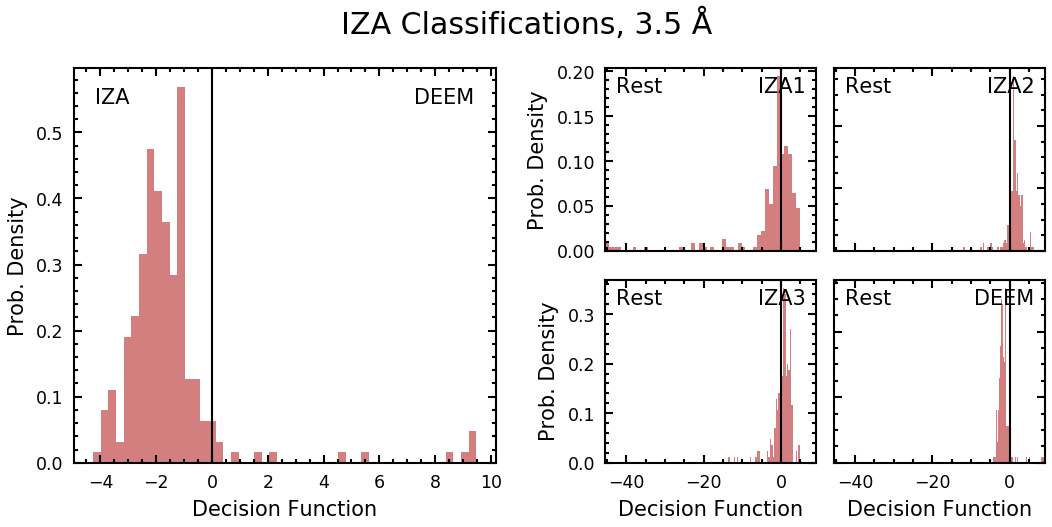

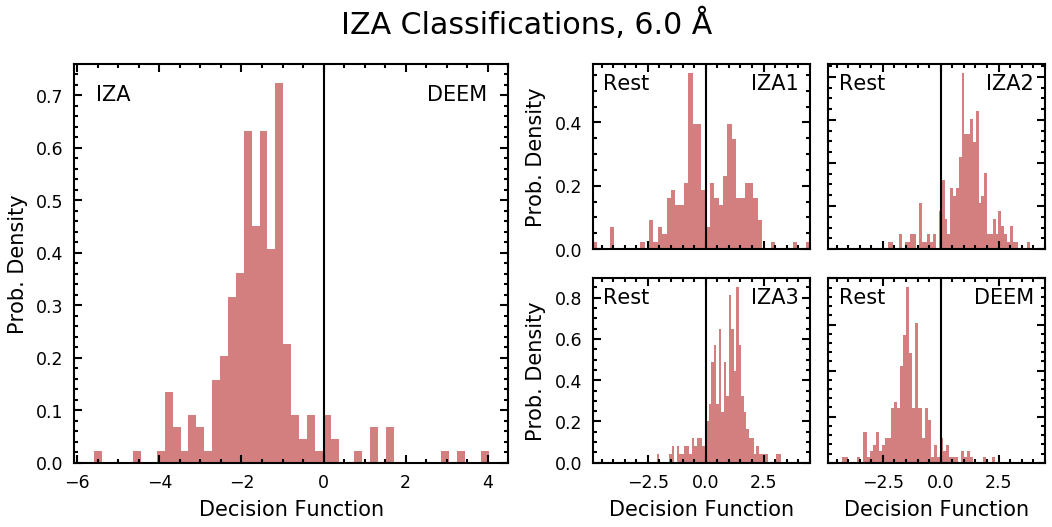

In [107]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(
        f'../../Processed_Data/IZA_230/Data/{cutoff}/LSVC/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    dfs_4 = np.loadtxt(
        f'../../Processed_Data/IZA_230/Data/{cutoff}/LSVC/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    histogram_parameters = dict(bins=50, density=True, log=False, color=color_list[1], alpha=0.5)

    df_4_min = np.amin(dfs_4)
    df_4_max = np.amax(dfs_4)

    # 2-Class histogram
    axs_2.hist(dfs_2, **histogram_parameters)
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color=color_list[0], linestyle='-')

    axs_2.text(
        0.05, 0.95, 
        class_names[2][0], 
        verticalalignment='top', horizontalalignment='left',
        transform=axs_2.transAxes
    )
    axs_2.text(
        0.95, 0.95, 
        class_names[2][1], 
        verticalalignment='top', horizontalalignment='right',
        transform=axs_2.transAxes
    )

    # 4-Class histograms
    for adx, ax in enumerate(axs_4):
        ax.hist(dfs_4[:, adx], **histogram_parameters)
        if adx > 1:
            ax.set_xlabel('Decision Function')
        else:
            ax.tick_params(
                which='both', axis='x',
                labelbottom=False
            )
        if adx % 2 == 0:
            ax.set_ylabel('Prob. Density')
        else:
            ax.tick_params(
                which='both', axis='y',
                labelleft=False
            )
        ax.axvline(0, color=color_list[0], linestyle='-')
        ax.set_xlim([df_4_min, df_4_max])

        ax.text(
            0.05, 0.95, 
            'Rest', 
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes
        )
        ax.text(
            0.95, 0.95, 
            class_names[4][adx], 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes
        )

    fig.suptitle(f'IZA Classifications, {cutoff} ' + u'\u00c5')

    #fig.savefig(f'../../Results/{cutoff}/df_iza_histogram_{cutoff}_power_OO+OSi+SiSi_lsvc.pdf', bbox_inches='tight')
    plt.show()

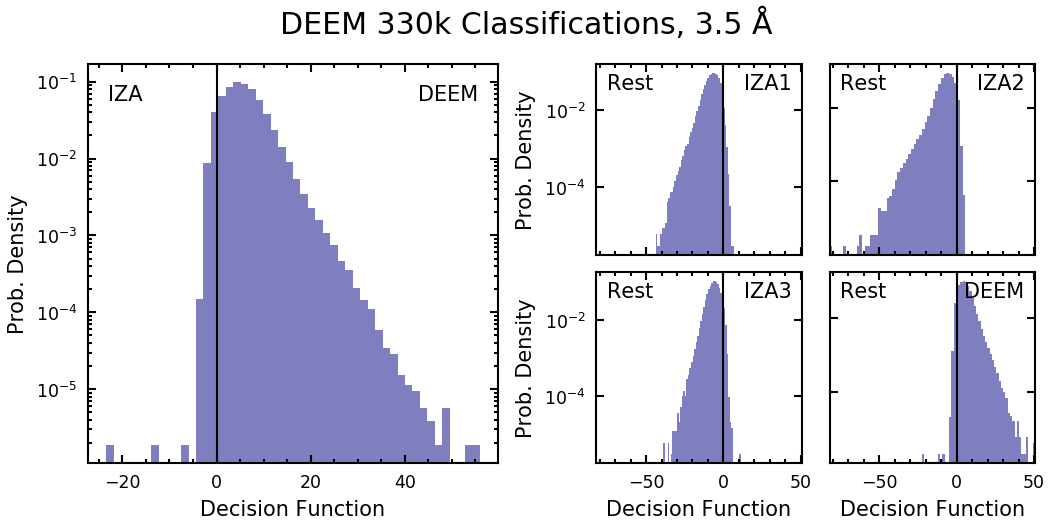

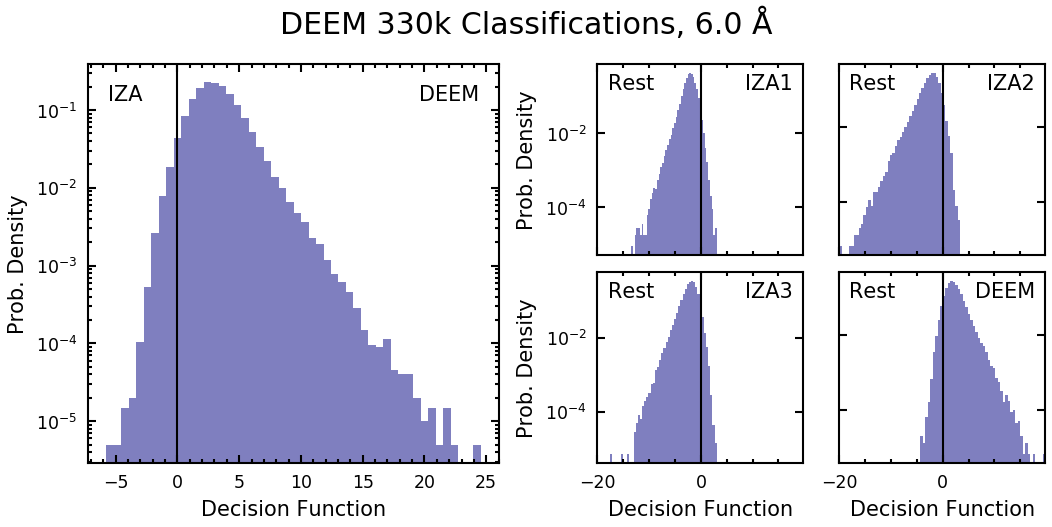

In [108]:
for cutoff in cutoffs:
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(
        f'../../Processed_Data/DEEM_330k/Data/{cutoff}/LSVC/2-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    dfs_4 = np.loadtxt(
        f'../../Processed_Data/DEEM_330k/Data/{cutoff}/LSVC/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat'
    )
    histogram_parameters = dict(bins=50, density=True, log=True, color=color_list[2], alpha=0.5)

    df_4_min = np.amin(dfs_4)
    df_4_max = np.amax(dfs_4)

    # 2-Class histogram
    axs_2.hist(dfs_2, **histogram_parameters)
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color=color_list[0], linestyle='-')

    axs_2.text(
        0.05, 0.95, 
        class_names[2][0], 
        verticalalignment='top', horizontalalignment='left',
        transform=axs_2.transAxes
    )
    axs_2.text(
        0.95, 0.95, 
        class_names[2][1], 
        verticalalignment='top', horizontalalignment='right',
        transform=axs_2.transAxes
    )

    # 4-Class histograms
    for adx, ax in enumerate(axs_4):
        ax.hist(dfs_4[:, adx], **histogram_parameters)
        if adx > 1:
            ax.set_xlabel('Decision Function')
        else:
            ax.tick_params(
                which='both', axis='x',
                labelbottom=False
            )
        if adx % 2 == 0:
            ax.set_ylabel('Prob. Density')
        else:
            ax.tick_params(
                which='both', axis='y',
                labelleft=False
            )
        ax.axvline(0, color=color_list[0], linestyle='-')
        ax.set_xlim([df_4_min, df_4_max])

        ax.text(
            0.05, 0.95, 
            'Rest', 
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes
        )
        ax.text(
            0.95, 0.95, 
            class_names[4][adx], 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes
        )

    fig.suptitle(f'DEEM 330k Classifications, {cutoff} ' + u'\u00c5')

    #fig.savefig(f'../../Results/{cutoff}/df_deem_histogram_{cutoff}_power_OO+OSi+SiSi_lsvc.pdf', bbox_inches='tight')
    plt.show()